# End-to-End FINN Flow for a 1D Convolutional Net (FINN v0.31b)
-----------------------------------------------------------------

FINN walkthrough for 1D CNN on Ultra96 for use in CG4002 by Daniel.

## Changelog

| Date | Changes |
|:------:|:---------:|
| 28/9/2020 | Added creation of CNN in section 1.1 (training not setup yet) |
| 29/9/2020 | Tweaked creation of CNN and added notes for finn compilation. Added basic training and testing, with a simple CNN being implemented |
| 5/10/2020 | Show accuracy and loss during training and cleaned up training code |
| 19/10/2020 | Added Brevitas Conv1D layers and create new 1D CNN |
| 20/10/2020 | Add extra 1D CNN using 16 inputs instead of 8, cleaned up notebook with end-to-end flow. |

## To Do
| |
|:------|
| Show hardware utilization by pulling logs from Vivado in /tmp/ |
| Clean up this notebook (FINN transformation parts) |
| Exporting to ONNX is not working for 1D CNN, for the hardware synthesis, copy over the FC layers, export and synthesize | 

## Quick Recap of the End-to-End Flow

The FINN compiler comes with many *transformations* that modify the ONNX representation of the network according to certain patterns. This notebook will demonstrate a *possible* sequence of such transformations to create a 1D CNN, train it and export to FINN.

![](finn-design-flow-example.svg)

In [1]:
# run this to install libaries, and restart the kernel for it to take effect

# download the whl file on this local machine
# restart the entire kernel after installation to have the notebook recognize modules
# toposort may not be needed, will delete if needed
!pip install /workspace/finn/notebooks/CNN/toposort-1.5-py2.py3-none-any.whl --user
!pip list | grep "toposort"

!pip install dependencies --user
!pip list | grep "dependencies"

!pip install pandas --user
!pip list | grep "pandas"

toposort                      1.5      
dependencies                  4.0.1    
pandas                        1.1.3    


In [57]:
# set the build directory and file name
build_dir = "/workspace/finn/notebooks/CNN"
file_name = "/cnn_1d_3_classes_sample_dataset"
model_path = "/cnv_1d_2_16.pt"

# exports a new model
create_new_model = True

# train the network, will implement loading of statedict later on
train_network = True

In [3]:
# all imports are put here
from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron

import datetime # for tracking time for each code block
import time

# 1. Brevitas Export, FINN Import and Tidy-Up

# 1.1 Network Setup

import torch
import torch.nn as nn
import torch.nn.init as init

from dependencies import Injector, value

from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType

import torch
from torch.nn import Module, ModuleList, BatchNorm2d, MaxPool2d, BatchNorm1d, MaxPool1d, Sequential

from brevitas.nn import QuantConv2d, QuantLinear
from brevitas.core.restrict_val import RestrictValueType

# 1.2 Training the Network

# imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from scipy import stats
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

# 1.3 Split Model into Conv1D and FC Layers
import torch.nn.functional as func

# 1.4 Export and Tidy-Up

import onnx
import brevitas.onnx as bo

from finn.core.modelwrapper import ModelWrapper
from finn.transformation.double_to_single_float import DoubleToSingleFloat
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames

# 2. How FINN Implements Convolutions: Lowering and Streamlining

from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC

# 3. Partitioning, Conversion to HLS Layers and Folding

import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (CreateDataflowPartition,)
from finn.custom_op.registry import getCustomOp

from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_tlastmarker import InsertTLastMarker
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
from finn.transformation.infer_datatypes import InferDataTypes

from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.util.basic import pynq_part_map

from finn.transformation.fpgadataflow.replace_verilog_relpaths import (ReplaceVerilogRelPaths,)
from finn.transformation.fpgadataflow.create_stitched_ip import CreateStitchedIP

from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_tlastmarker import InsertTLastMarker
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
from finn.transformation.infer_datatypes import InferDataTypes

import toposort
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_datatypes import InferDataTypes

# 4. Hardware Generation

import os
import subprocess

from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ

from finn.custom_op.registry import getCustomOp
from finn.transformation import Transformation
from finn.core.modelwrapper import ModelWrapper
from finn.util.basic import get_by_name, make_build_dir
from finn.util.basic import get_num_default_workers
from finn.util.basic import pynq_part_map

from finn.transformation.fpgadataflow.create_dataflow_partition import (CreateDataflowPartition,)
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.transformation.fpgadataflow.create_stitched_ip import CreateStitchedIP
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames
from shutil import copy
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver

# 5. Deployment and Remote Execution

import pkg_resources as pk
import matplotlib.pyplot as plt
import numpy as np

from finn.custom_op.registry import getCustomOp

import numpy as np
from finn.core.onnx_exec import execute_onnx

## 1. Preparing, Training and Exporting the Network

## 1.1 Network Setup

Declare the network below, and then create the CNN.

Note that you may have to trail and error for this part.

In [107]:
# declare features of the CNN

# notes on CNN structure:
# conv layers should have alternating maxpool layers, and the last layer should not be a max pool layer
# last layer needs Sequential() to flatten for the fully connected layers
#
# maxpool layers must have their input size be divisible by kernel size, this is mandatory
# Conv1D is non-synthesizeable under FINN 0.3b

# QuantConv1d configuration (i, OUT_CH, is_maxpool_enabled)
CNV_OUT_CH_POOL = [(0, 16, False), (1, 32, True), (2, 64, False), (3, 128, False)]
KERNEL_SIZE = 3 # default 3
NUM_CONV_LAYERS = 3

# Intermediate QuantLinear configuration
INTERMEDIATE_FC_PER_OUT_CH_SCALING = True
INTERMEDIATE_FC_FEATURES = [(256, 128)] # (IN_CH, OUT_CH)

# Last QuantLinear configuration
LAST_FC_IN_FEATURES = 128
LAST_FC_PER_OUT_CH_SCALING = False

# MaxPool2d configuration
POOL_SIZE = 2

# Network specific bit-widths and IO
WEIGHT_BIT_WIDTH = 1
ACT_BIT_WIDTH = 1
IN_BIT_WIDTH = 8
NUM_CLASSES = 3
IN_CHANNELS = 2

# only use inputs that are multiples of 4
INPUT_SPECIFICATIONS = (1, 2, 16) # batch size, channels, length

classes = ["shrug", "zigzag", "windows"]

"""
# network for CNV_1w1a
# QuantConv2d configuration (IN_CH, OUT_CH, bias)
CNV_OUT_CH_POOL = [(0, 64, False), (1, 64, True), (2, 128, False), (3, 128, True), (4, 256, False), (5, 256, False)]

# Intermediate QuantLinear configuration
INTERMEDIATE_FC_PER_OUT_CH_SCALING = True
INTERMEDIATE_FC_FEATURES = [(256, 512), (512, 512)] # (IN_CH, OUT_CH)

# Last QuantLinear configuration
LAST_FC_IN_FEATURES = 512
LAST_FC_PER_OUT_CH_SCALING = False

# MaxPool2d configuration
POOL_SIZE = 2

# Network specific bit-widths and IO
WEIGHT_BIT_WIDTH = 1
ACT_BIT_WIDTH = 1
IN_BIT_WIDTH = 8
NUM_CLASSES = 10
IN_CHANNELS = 3

INPUT_SPECIFICATIONS = (1, 3, 32, 32)
"""

'\n# network for CNV_1w1a\n# QuantConv2d configuration (IN_CH, OUT_CH, bias)\nCNV_OUT_CH_POOL = [(0, 64, False), (1, 64, True), (2, 128, False), (3, 128, True), (4, 256, False), (5, 256, False)]\n\n# Intermediate QuantLinear configuration\nINTERMEDIATE_FC_PER_OUT_CH_SCALING = True\nINTERMEDIATE_FC_FEATURES = [(256, 512), (512, 512)] # (IN_CH, OUT_CH)\n\n# Last QuantLinear configuration\nLAST_FC_IN_FEATURES = 512\nLAST_FC_PER_OUT_CH_SCALING = False\n\n# MaxPool2d configuration\nPOOL_SIZE = 2\n\n# Network specific bit-widths and IO\nWEIGHT_BIT_WIDTH = 1\nACT_BIT_WIDTH = 1\nIN_BIT_WIDTH = 8\nNUM_CLASSES = 10\nIN_CHANNELS = 3\n\nINPUT_SPECIFICATIONS = (1, 3, 32, 32)\n'

In [5]:
# QuantConv1D as per https://github.com/Xilinx/brevitas/blob/quant_quartznet_4b-r0/brevitas/nn/quant_conv1d.py
from enum import auto
from typing import Union, Optional, Tuple
import re

import math
import torch
import docrep
from torch.nn import Conv1d, Module
from torch.nn import functional as F
from torch.nn.functional import conv1d
from torch.nn.parameter import Parameter

from brevitas.core.bit_width import BitWidthParameter, BitWidthConst, BitWidthImplType
from brevitas.core.quant import QuantType, IdentityQuant
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType, SCALING_SCALAR_SHAPE
from brevitas.core.stats import StatsInputViewShapeImpl, StatsOp
from brevitas.function.ops import max_uint, ceil_ste
#from brevitas.function.ops_ste import ceil_ste
from brevitas.proxy.parameter_quant import WeightQuantProxy, BiasQuantProxy, WeightReg
from brevitas.utils.python_utils import AutoName
from brevitas.nn.quant_layer import QuantLayer, SCALING_MIN_VAL
from brevitas.config import docstrings
__all__ = ['QuantConv1d']


class PaddingType(AutoName):
    STANDARD = auto()
    SAME = auto()


@docstrings.dedent
class QuantConv1d(QuantLayer, Conv1d):
    """
        Parameters
        ----------
        %(weight_quant_proxy.parameters_with_prefix)s
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int, Tuple[int]],
                 stride: Union[int, Tuple[int]] = 1,
                 padding: Union[int, Tuple[int]] = 0,
                 padding_type: PaddingType = PaddingType.STANDARD,
                 dilation: Union[int, Tuple[int]] = 1,
                 groups: int = 1,
                 bias: bool = True,
                 bias_quant_type: QuantType = QuantType.FP,
                 bias_narrow_range: bool = False,
                 bias_bit_width: int = None,
                 weight_quant_override: WeightQuantProxy = None,
                 weight_quant_type: QuantType = QuantType.FP,
                 weight_narrow_range: bool = False,
                 weight_scaling_override: Optional[Module] = None,
                 weight_bit_width_impl_override: Union[BitWidthParameter, BitWidthConst] = None,
                 weight_bit_width_impl_type: BitWidthImplType = BitWidthImplType.CONST,
                 weight_restrict_bit_width_type: RestrictValueType = RestrictValueType.INT,
                 weight_bit_width: int = 32,
                 weight_min_overall_bit_width: Optional[int] = 2,
                 weight_max_overall_bit_width: Optional[int] = None,
                 weight_scaling_impl_type: ScalingImplType = ScalingImplType.STATS,
                 weight_scaling_const: Optional[float] = None,
                 weight_scaling_stats_op: StatsOp = StatsOp.MAX,
                 weight_scaling_per_output_channel: bool = False,
                 weight_ternary_threshold: float = 0.5,
                 weight_restrict_scaling_type: RestrictValueType = RestrictValueType.LOG_FP,
                 weight_scaling_stats_sigma: float = 3.0,
                 weight_scaling_min_val: float = SCALING_MIN_VAL,
                 weight_override_pretrained_bit_width: bool = False,
                 compute_output_scale: bool = False,
                 compute_output_bit_width: bool = False,
                 return_quant_tensor: bool = False) -> None:
        QuantLayer.__init__(self,
                            compute_output_scale=compute_output_scale,
                            compute_output_bit_width=compute_output_bit_width,
                            return_quant_tensor=return_quant_tensor)
        Conv1d.__init__(self,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                        groups=groups,
                        bias=bias)
        if weight_quant_type == QuantType.FP and compute_output_bit_width:
            raise Exception("Computing output bit width requires enabling quantization")
        if bias_quant_type != QuantType.FP and not (compute_output_scale and compute_output_bit_width):
            raise Exception("Quantizing bias requires to compute output scale and output bit width")

        self.per_elem_ops = 2 * self.kernel_size[0] * (in_channels // groups)
        self.padding_type = padding_type
        self.weight_reg = WeightReg()

        if weight_quant_override is not None:
            self.weight_quant = weight_quant_override
            self.weight_quant.add_tracked_parameter(self.weight)
        else:
            weight_scaling_stats_input_concat_dim = 1
            if weight_scaling_per_output_channel:
                weight_stats_input_view_shape_impl = StatsInputViewShapeImpl.OVER_OUTPUT_CHANNELS
                weight_scaling_shape = self.per_output_channel_broadcastable_shape
                weight_scaling_stats_reduce_dim = 1
            else:
                weight_stats_input_view_shape_impl = StatsInputViewShapeImpl.OVER_TENSOR
                weight_scaling_shape = SCALING_SCALAR_SHAPE
                weight_scaling_stats_reduce_dim = None

            if weight_scaling_stats_op == StatsOp.MAX_AVE:
                weight_stats_input_view_shape_impl = StatsInputViewShapeImpl.OVER_OUTPUT_CHANNELS
                weight_scaling_stats_reduce_dim = 1

            self.weight_quant = WeightQuantProxy(bit_width=weight_bit_width,
                                                 quant_type=weight_quant_type,
                                                 narrow_range=weight_narrow_range,
                                                 scaling_override=weight_scaling_override,
                                                 restrict_scaling_type=weight_restrict_scaling_type,
                                                 scaling_const=weight_scaling_const,
                                                 scaling_stats_op=weight_scaling_stats_op,
                                                 scaling_impl_type=weight_scaling_impl_type,
                                                 scaling_stats_reduce_dim=weight_scaling_stats_reduce_dim,
                                                 scaling_shape=weight_scaling_shape,
                                                 bit_width_impl_type=weight_bit_width_impl_type,
                                                 bit_width_impl_override=weight_bit_width_impl_override,
                                                 restrict_bit_width_type=weight_restrict_bit_width_type,
                                                 min_overall_bit_width=weight_min_overall_bit_width,
                                                 max_overall_bit_width=weight_max_overall_bit_width,
                                                 tracked_parameter_list_init=self.weight,
                                                 ternary_threshold=weight_ternary_threshold,
                                                 scaling_stats_input_view_shape_impl=weight_stats_input_view_shape_impl,
                                                 scaling_stats_input_concat_dim=weight_scaling_stats_input_concat_dim,
                                                 scaling_stats_sigma=weight_scaling_stats_sigma,
                                                 scaling_min_val=weight_scaling_min_val,
                                                 override_pretrained_bit_width=weight_override_pretrained_bit_width)
        self.bias_quant = BiasQuantProxy(quant_type=bias_quant_type,
                                         bit_width=bias_bit_width,
                                         narrow_range=bias_narrow_range)

    @property
    def per_output_channel_broadcastable_shape(self):
        if self.transposed:
            raise Exception("Transposed filters are not supported.")
        else:
            output_dim = 0
        per_channel_size = [1] * len(self.weight.size())
        per_channel_size[output_dim] = self.out_channels
        per_channel_size = tuple(per_channel_size)
        return per_channel_size

    @property
    def int_weight(self):
        if isinstance(self.weight_quant.tensor_quant, IdentityQuant):
            raise Exception("Can't export int weight without quantization enabled")
        return self.weight_quant.int_weight(self.weight)

    @property
    def quant_weight_scale(self):
        """
        Returns scale factor of the quantized weights with scalar () shape or (self.out_channels, 1, 1)
        shape depending on whether scaling is per layer or per-channel.
        -------
        """
        if isinstance(self.weight_quant.tensor_quant, IdentityQuant):
            raise Exception("Can't generate scaling factor without quantization enabled")
        zero_hw_sentinel = self.weight_quant.zero_hw_sentinel
        _, scale, _ = self.weight_quant.tensor_quant(self.weight, zero_hw_sentinel)
        return scale

    def forward(self, input):
        output_scale = None
        output_bit_width = None
        quant_bias_bit_width = None

        input, input_scale, input_bit_width = self.unpack_input(input)
        quant_weight, quant_weight_scale, quant_weight_bit_width = self.weight_quant(self.weight)
        quant_weight = self.weight_reg(quant_weight)

        if self.compute_output_bit_width:
            assert input_bit_width is not None
            output_bit_width = self.max_output_bit_width(input_bit_width, quant_weight_bit_width)
        if self.compute_output_scale:
            assert input_scale is not None
            output_scale = input_scale * quant_weight_scale

        if self.bias is not None:
            quant_bias, _, quant_bias_bit_width = self.bias_quant(self.bias, output_scale, output_bit_width)
            output = self.conv1d(input, quant_weight, quant_bias)
        else:
            output = self.conv1d(input, quant_weight, None)

        if self.compute_output_bit_width and quant_bias_bit_width is not None:
            output_bit_width = torch.where(quant_bias_bit_width > output_bit_width,
                                           quant_bias_bit_width,
                                           output_bit_width)

        return self.pack_output(output, output_scale, output_bit_width)

    def conv1d(self, x, weight, bias):
        if self.padding_type == PaddingType.SAME:
            out = self.conv1d_same_padding(x, weight, bias)
        else:
            out = conv1d(x, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        return out

    def conv1d_same_padding(self, x, weight, bias):
        ih = x.size()[-1]
        kh = weight.size()[-1]
        sh = self.stride[0]
        oh = math.ceil(ih / sh)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        if pad_h > 0:
            x = F.pad(x, [pad_h // 2, pad_h - pad_h // 2])
        out = F.conv1d(x, weight, bias, self.stride, 0, self.dilation, self.groups)
        return out

    def merge_bn_in(self, bn, affine_only, sign_only):
        raise Exception("Merged Batch-Normalization is not yet supported")

    def max_output_bit_width(self, input_bit_width, weight_bit_width):
        max_uint_input = max_uint(bit_width=input_bit_width, narrow_range=False)
        max_kernel_val = self.weight_quant.tensor_quant.int_quant.max_uint(weight_bit_width)
        group_size = self.out_channels // self.groups
        max_uint_output = max_uint_input * max_kernel_val * self.kernel_size[0] * group_size
        max_output_bit_width = ceil_ste(torch.log2(max_uint_output))
        return max_output_bit_width

In [6]:
# common
from brevitas.core.bit_width import BitWidthImplType
from brevitas.core.quant import QuantType
from brevitas.core.restrict_val import RestrictValueType
from brevitas.core.scaling import ScalingImplType
from brevitas.core.stats import StatsOp
from brevitas.nn import QuantConv2d, QuantHardTanh, QuantLinear

# Quant common
BIT_WIDTH_IMPL_TYPE = BitWidthImplType.CONST
SCALING_VALUE_TYPE = RestrictValueType.LOG_FP
SCALING_IMPL_TYPE = ScalingImplType.PARAMETER
NARROW_RANGE_ENABLED = True

# Weight quant common
STATS_OP = StatsOp.MEAN_LEARN_SIGMA_STD
BIAS_ENABLED = False
WEIGHT_SCALING_IMPL_TYPE = ScalingImplType.STATS
SIGMA = 0.001

# QuantHardTanh configuration
HARD_TANH_MIN = -1.0
HARD_TANH_MAX = 1.0
ACT_PER_OUT_CH_SCALING = False

# QuantConv2d configuration
CONV_PER_OUT_CH_SCALING = True

def get_stats_op(quant_type):
    if quant_type == QuantType.BINARY:
        return StatsOp.AVE
    else:
        return StatsOp.MAX


def get_quant_type(bit_width):
    if bit_width is None:
        return QuantType.FP
    elif bit_width == 1:
        return QuantType.BINARY
    else:
        return QuantType.INT


def get_act_quant(act_bit_width, act_quant_type):
    if act_quant_type == QuantType.INT:
        act_scaling_impl_type = ScalingImplType.PARAMETER
    else:
        act_scaling_impl_type = ScalingImplType.CONST
    return QuantHardTanh(quant_type=act_quant_type,
                         bit_width=act_bit_width,
                         bit_width_impl_type=BIT_WIDTH_IMPL_TYPE,
                         min_val=HARD_TANH_MIN,
                         max_val=HARD_TANH_MAX,
                         scaling_impl_type=act_scaling_impl_type,
                         restrict_scaling_type=SCALING_VALUE_TYPE,
                         scaling_per_channel=ACT_PER_OUT_CH_SCALING,
                         narrow_range=NARROW_RANGE_ENABLED)


def get_quant_linear(in_features, out_features, per_out_ch_scaling, bit_width, quant_type, stats_op):
    return QuantLinear(bias=BIAS_ENABLED,
                       in_features=in_features,
                       out_features=out_features,
                       weight_quant_type=quant_type,
                       weight_narrow_range=NARROW_RANGE_ENABLED,
                       weight_bit_width=bit_width,
                       weight_bit_width_impl_type=BIT_WIDTH_IMPL_TYPE,
                       weight_scaling_per_output_channel=per_out_ch_scaling,
                       weight_scaling_stats_op=stats_op,
                       weight_scaling_stats_sigma=SIGMA)


def get_quant_conv2d(in_ch, out_ch, bit_width, quant_type, stats_op):
    return QuantConv2d(in_channels=in_ch,
                       kernel_size=KERNEL_SIZE,
                       out_channels=out_ch,
                       weight_quant_type=quant_type,
                       weight_bit_width=bit_width,
                       weight_narrow_range=NARROW_RANGE_ENABLED,
                       weight_scaling_impl_type=WEIGHT_SCALING_IMPL_TYPE,
                       weight_scaling_stats_op=stats_op,
                       weight_scaling_stats_sigma=SIGMA,
                       weight_scaling_per_output_channel=CONV_PER_OUT_CH_SCALING,
                       weight_restrict_scaling_type=SCALING_VALUE_TYPE,
                       weight_bit_width_impl_type=BIT_WIDTH_IMPL_TYPE,
                       bias=BIAS_ENABLED)

def get_quant_conv1d(in_ch, out_ch, bit_width, quant_type, stats_op):
    return QuantConv1d(in_channels=in_ch,
                       kernel_size=KERNEL_SIZE,
                       out_channels=out_ch,
                       weight_quant_type=quant_type,
                       weight_bit_width=bit_width,
                       weight_narrow_range=NARROW_RANGE_ENABLED,
                       weight_scaling_impl_type=WEIGHT_SCALING_IMPL_TYPE,
                       weight_scaling_stats_op=stats_op,
                       weight_scaling_stats_sigma=SIGMA,
                       weight_scaling_per_output_channel=CONV_PER_OUT_CH_SCALING,
                       weight_restrict_scaling_type=SCALING_VALUE_TYPE,
                       weight_bit_width_impl_type=BIT_WIDTH_IMPL_TYPE,
                       bias=BIAS_ENABLED)

In [7]:
# declare the classes needed for the CNN, taken from: https://github.com/maltanar/brevitas_cnv_lfc
# this is where the pre-trained models also come from, however, we will import the whole thing here to make custom CNNs
class CNV(Module):

    def __init__(self, num_classes=10, weight_bit_width=None, act_bit_width=None,in_bit_width=None, in_ch=3, device="cpu"):
        super(CNV, self).__init__()
        self.device = device

        weight_quant_type = get_quant_type(weight_bit_width)
        act_quant_type = get_quant_type(act_bit_width)
        in_quant_type = get_quant_type(in_bit_width)
        stats_op = get_stats_op(weight_quant_type)

        self.conv_features = ModuleList()
        self.linear_features = ModuleList()
        self.conv_features.append(get_act_quant(in_bit_width, in_quant_type))

        # convolution layers
        for i, out_ch, is_pool_enabled in CNV_OUT_CH_POOL:
            self.conv_features.append(get_quant_conv1d(in_ch=in_ch,
                                                       out_ch=out_ch,
                                                       bit_width=weight_bit_width,
                                                       quant_type=weight_quant_type,
                                                       stats_op=stats_op))
            in_ch = out_ch
            self.conv_features.append(BatchNorm1d(in_ch))
            if i == (NUM_CONV_LAYERS - 1):
                self.conv_features.append(Sequential())
            self.conv_features.append(get_act_quant(act_bit_width, act_quant_type))
            if is_pool_enabled:
                self.conv_features.append(MaxPool1d(kernel_size=2))

        # fully connected layers
        for in_features, out_features in INTERMEDIATE_FC_FEATURES:
            self.linear_features.append(get_quant_linear(in_features=in_features,
                                                         out_features=out_features,
                                                         per_out_ch_scaling=INTERMEDIATE_FC_PER_OUT_CH_SCALING,
                                                         bit_width=weight_bit_width,
                                                         quant_type=weight_quant_type,
                                                         stats_op=stats_op))
            self.linear_features.append(BatchNorm1d(out_features))
            self.linear_features.append(get_act_quant(act_bit_width, act_quant_type))
            
        # last layer
        self.fc = get_quant_linear(in_features=LAST_FC_IN_FEATURES,
                                   out_features=num_classes,
                                   per_out_ch_scaling=LAST_FC_PER_OUT_CH_SCALING,
                                   bit_width=weight_bit_width,
                                   quant_type=weight_quant_type,
                                   stats_op=stats_op)

    def forward(self, x):
        x = 2.0 * x - torch.tensor([1.0]).to(self.device)
        for mod in self.conv_features:
            x = mod(x)
        x = x.view(x.shape[0], -1)
        
        for mod in self.linear_features:
            x = mod(x)
        out = self.fc(x)
        return out

# will not be used as we wont use cfg
def cnv(cfg):
    weight_bit_width = cfg.getint('QUANT', 'WEIGHT_BIT_WIDTH')
    act_bit_width = cfg.getint('QUANT', 'ACT_BIT_WIDTH')
    in_bit_width = cfg.getint('QUANT', 'IN_BIT_WIDTH')
    num_classes = cfg.getint('MODEL', 'NUM_CLASSES')
    in_channels = cfg.getint('MODEL', 'IN_CHANNELS')
    net = CNV(weight_bit_width=weight_bit_width,
              act_bit_width=act_bit_width,
              in_bit_width=in_bit_width,
              num_classes=num_classes,
              in_ch=in_channels)
    return net

def cnv_manual(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS):
    net = CNV(weight_bit_width=WEIGHT_BIT_WIDTH,
              act_bit_width=ACT_BIT_WIDTH,
              in_bit_width=IN_BIT_WIDTH,
              num_classes=NUM_CLASSES,
              in_ch=IN_CHANNELS)
    return net

In [8]:
# create the model and export
bnn_pynq_model = cnv_manual(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS)

# print for reference
print(bnn_pynq_model) 

CNV(
  (conv_features): ModuleList(
    (0): QuantHardTanh(
      (act_quant_proxy): ActivationQuantProxy(
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RestrictValue(
                (forward_impl): Sequential(
                  (0): RoundSte()
                  (1): Identity()
                )
              )
              (tensor_clamp_impl): TensorClamp()
            )
            (scaling_impl): StandaloneScaling(
              (restrict_value): RestrictValue(
                (forward_impl): Sequential(
                  (0): PowerOfTwo()
                  (1): ClampMin()
                )
              )
            )
            (int_scaling_impl): IntScaling(
              (forward_impl): SignedFpIntScale()
            )
            (msb_clamp_bit_width_impl): BitWidthConst()
          )
        )
      

## 1.2 Training the Network


In [10]:
# import the data from csv
df = pd.read_csv('dataset_3classes_2_16.csv')

df.shape

(24575, 3)

In [11]:
# stitch together 8 inputs (1x8) to make a 8x8 input, and make the training / testing data

def parse_input(df, starting_index):
    data = np.array(((df.iloc[starting_index, 0],df.iloc[starting_index + 1,0],df.iloc[starting_index + 2,0],df.iloc[starting_index + 3,0],df.iloc[starting_index + 4,0],df.iloc[starting_index + 5,0],df.iloc[starting_index + 6,0],df.iloc[starting_index + 7,0],
                  df.iloc[starting_index + 8, 0], df.iloc[starting_index + 9, 0], df.iloc[starting_index + 10, 0], df.iloc[starting_index + 11, 0], df.iloc[starting_index + 12, 0], df.iloc[starting_index + 13, 0], df.iloc[starting_index + 14, 0], df.iloc[starting_index + 15, 0]),
                 (df.iloc[starting_index, 1],df.iloc[starting_index + 1, 1],df.iloc[starting_index + 2, 1],df.iloc[starting_index + 3, 1],df.iloc[starting_index + 4, 1],df.iloc[starting_index + 5, 1],df.iloc[starting_index + 6, 1],df.iloc[starting_index + 7, 1], 
                  df.iloc[starting_index + 8, 1], df.iloc[starting_index + 9, 1], df.iloc[starting_index + 10, 1], df.iloc[starting_index + 11, 1], df.iloc[starting_index + 12, 1], df.iloc[starting_index + 13, 1], df.iloc[starting_index + 14, 1], df.iloc[starting_index + 15, 1])))
    return data

# 20% set aside for testing
num_items = (df.shape[0]) // 8
max_data = 900
batch_size = 2

x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []

for i in range(num_items):
    if i == max_data:
        break
    starting_index = i * 8 * (num_items // max_data)
    
    # 16 inputs
    data = parse_input(df, starting_index)
    
    # do encoding, go by index as shown below
    if 'shrug' in df.iloc[starting_index, 2]:
        value = (0)
    elif 'zigzag' in df.iloc[starting_index, 2]:
        value = (1)
    elif 'windows' in df.iloc[starting_index, 2]:
        value = (2)
    else:
        continue
    
    if i % 5 != 4: # training
        x_train_list.append(data)
        y_train_list.append(value) 
    else: # testing
        x_test_list.append(data)
        y_test_list.append(value)
        
# remove extra inputs that cannot fit in batch_size
while len(x_train_list) % batch_size != 0:
    x_train_list.pop()
    y_train_list.pop()
    
while len(x_test_list) % batch_size != 0:
    x_test_list.pop()
    y_test_list.pop()
        
# transform to PyTorch DataLoader
tensor_x_train = torch.Tensor(x_train_list) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train_list)
    
print(tensor_x_train.size())

dataset_train = TensorDataset(tensor_x_train,tensor_y_train)
train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 1)

tensor_x_test = torch.Tensor(x_test_list) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test_list)
    
print(tensor_x_test.size())

dataset_test = TensorDataset(tensor_x_test,tensor_y_test)
test_loader = DataLoader(dataset_test, batch_size = batch_size, shuffle = True, num_workers = 1)

torch.Size([720, 2, 16])
torch.Size([180, 2, 16])


In [12]:
# validate input data size
for data, target in train_loader:
    print(data.shape)
    break

torch.Size([2, 2, 16])


In [16]:
# settings for training
from torch.utils.data import DataLoader

LEARNING_RATE = 0.01
MOMENTUM = 0.1
WEIGHT_DECAY = 0.0001

# Loss function
criterion = nn.CrossEntropyLoss()

log_freq = 10

EPOCHS = 25 # we'll see how long it takes first

In [14]:
device = 'cpu' # linux CUDA not set up yet

# training stuff
# like the CNN model, it is taken from https://github.com/maltanar/brevitas_cnv_lfc
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TrainingEpochMeters(object):
    def __init__(self):
        self.batch_time = AverageMeter()
        self.data_time = AverageMeter()
        self.losses = AverageMeter()
        self.top1 = AverageMeter()
        self.top5 = AverageMeter()

class EvalEpochMeters(object):
    def __init__(self):
        self.model_time = AverageMeter()
        self.loss_time = AverageMeter()
        self.losses = AverageMeter()
        self.top1 = AverageMeter()
        self.top5 = AverageMeter()

def eval_model(epoch=None):
    eval_meters = EvalEpochMeters()

    # switch to evaluate mode
    bnn_pynq_model.eval()
    criterion.eval()

    for i, data in enumerate(test_loader):

        end = time.time()
        (input, target) = data

        input = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = bnn_pynq_model(input)

        # measure model elapsed time
        eval_meters.model_time.update(time.time() - end)
        end = time.time()

        #compute loss
        loss = criterion(output, target.long())
        eval_meters.loss_time.update(time.time() - end)

        prec1, prec5 = accuracy(output, target, topk=(1, NUM_CLASSES))
        eval_meters.losses.update(loss.item(), input.size(0))
        eval_meters.top1.update(prec1.item(), input.size(0))
        eval_meters.top5.update(prec5.item(), input.size(0))

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred).long())

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def softmax_train(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_prediction_train(output_tensor):
    prediction_list = softmax_train(output_tensor.tolist())
    max_val = -1
    prediction = 0
    for i in range(len(prediction_list)):
        if prediction_list[i] > max_val:
            max_val = prediction_list[i]
            prediction = i
    
    return prediction

# returns the number of correct predictions
def compare_output(output, target):
    running_total = 0
    
    # iterate for each item in 
    for i in range(len(output)):
        if get_prediction_train(output[i]) == int(target.tolist()[i]):
            running_total += 1
    
    return running_total
        
def train_model():
    optimizer = optim.SGD(bnn_pynq_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    # training starts
    torch.autograd.set_detect_anomaly(True)

    # keep track of training / testing metrics
    num_inputs_training = len(train_loader) * batch_size
    num_inputs_testing = len(test_loader) * batch_size
        
    for epoch in range(EPOCHS):
        # keep track of training / testing metrics
        running_loss_training = 0.0
        running_loss_testing = 0.0
        num_inputs_training_correct = 0
        num_inputs_testing_correct = 0

        # Set to training mode
        bnn_pynq_model.train()
        criterion.train()

        # Init metrics
        epoch_meters = TrainingEpochMeters()
        start_data_loading = time.time()

        for i, data in enumerate(train_loader):
            (input, target) = data
            #print("input", input)
            #print("target", target)
            
            input = input.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            
            # measure data loading time
            epoch_meters.data_time.update(time.time() - start_data_loading)

            # Training batch starts
            start_batch = time.time()
            output = bnn_pynq_model(input)
            loss = criterion(output, target.long())

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            epoch_meters.batch_time.update(time.time() - start_batch)
            if i % int(log_freq) == 0 or i == len(train_loader) - 1:
                # set the third value of topk depending on the number of classes
                prec1, prec5 = accuracy(output.detach(), target, topk=(1, NUM_CLASSES))
                epoch_meters.losses.update(loss.item(), input.size(0))
                epoch_meters.top1.update(prec1.item(), input.size(0))
                epoch_meters.top5.update(prec5.item(), input.size(0))
                #self.logger.training_batch_cli_log(epoch_meters, epoch, i, len(self.train_loader))
                
            # update loss and accuracy
            running_loss_training += loss.item()
            num_inputs_training_correct += compare_output(output, target.long())

            # training batch ends
            #start_data_loading = time.time()
            
        # validate
        for j, data in enumerate(test_loader):
            (input, target) = data
            
            input = input.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            
            output = bnn_pynq_model(input)
            loss = criterion(output, target.long())
        
            # update loss and accuracy
            running_loss_testing += loss.item()
            num_inputs_testing_correct += compare_output(output, target.long())
            
        print('Epoch [%d] (took %.3f) training loss: %.3f, accuracy: %.3f, validation loss: %.3f, accuracy: %.3f' 
              % (epoch + 1, time.time() - start_data_loading, running_loss_training / num_inputs_training, num_inputs_training_correct / num_inputs_training, 
                running_loss_testing / num_inputs_testing, num_inputs_testing_correct / num_inputs_testing))
        running_loss = 0.0
        
        # Perform eval
        with torch.no_grad():
            top1avg = eval_model(epoch)

In [18]:
# train the model
# to do: put up accuracy / loss

if train_network:
    train_model()
    #bo.export_finn_onnx(bnn_pynq_model, INPUT_SPECIFICATIONS, build_dir + file_name + ".onnx")

Epoch [1] (took 41.889) training loss: 0.496, accuracy: 0.503, validation loss: 0.437, accuracy: 0.650
Epoch [2] (took 41.234) training loss: 0.389, accuracy: 0.694, validation loss: 0.354, accuracy: 0.639
Epoch [3] (took 41.943) training loss: 0.331, accuracy: 0.729, validation loss: 0.302, accuracy: 0.756
Epoch [4] (took 42.769) training loss: 0.309, accuracy: 0.761, validation loss: 0.267, accuracy: 0.783
Epoch [5] (took 49.936) training loss: 0.280, accuracy: 0.812, validation loss: 0.361, accuracy: 0.767
Epoch [6] (took 41.346) training loss: 0.317, accuracy: 0.776, validation loss: 0.282, accuracy: 0.761
Epoch [7] (took 38.242) training loss: 0.326, accuracy: 0.776, validation loss: 0.275, accuracy: 0.811
Epoch [8] (took 35.404) training loss: 0.261, accuracy: 0.796, validation loss: 0.286, accuracy: 0.728
Epoch [9] (took 35.857) training loss: 0.234, accuracy: 0.825, validation loss: 0.246, accuracy: 0.844
Epoch [10] (took 35.350) training loss: 0.317, accuracy: 0.768, validatio

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [19]:
torch.save(bnn_pynq_model.state_dict(), build_dir + model_path)

In [20]:
# show statistics
num_inputs_train_stats = 0
num_inputs_test_stats = 0

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_prediction(output_tensor):
    prediction_list = softmax(output_tensor.tolist())
    max_val = -1
    prediction = 0
    for i in range(len(prediction_list)):
        if prediction_list[i] > max_val:
            max_val = prediction_list[i]
            prediction = i
    
    return prediction

def test_on_everything(print_output):

    list_input_train_total = [0, 0, 0]
    list_input_train_correct_total = [0, 0, 0]
    
    for i, data in enumerate(train_loader):
        (input, target) = data
        input = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        output = bnn_pynq_model(input)
        #print(target, output)

        for i in range(len(output)):
            if print_output:
                print(softmax(output[i].tolist()), "prediction", get_prediction(output[i]), "target", target[i].tolist())

            list_input_train_total[int(target[i].tolist())] += 1

            if int(target[i].tolist()) == get_prediction(output[i]):
                list_input_train_correct_total[int(target[i].tolist())] += 1

    for i, data in enumerate(test_loader):
        (input, target) = data
        input = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        output = bnn_pynq_model(input)

        for i in range(len(output)):
            if print_output:
                print(softmax(output[i].tolist()), "prediction", get_prediction(output[i]), "target", target[i].tolist())

            list_input_train_total[int(target[i].tolist())] += 1

            if int(target[i].tolist()) == get_prediction(output[i]):
                list_input_train_correct_total[int(target[i].tolist())] += 1    

    print("number of inputs of each class", list_input_train_total)
    print("correctly predicted", list_input_train_correct_total)

    running_total = 0
    running_total_correct = 0
    for i in range(len(list_input_train_total)):
        print("correctly predicted class %d at %.3f" % ((i + 1), (list_input_train_correct_total[i] * 100 / list_input_train_total[i])))
        running_total += list_input_train_total[i]
        running_total_correct += list_input_train_correct_total[i]
    
    print("accuracy at %.3f" % ((running_total_correct * 100 / running_total)))
    
test_on_everything(print_output = True)

[0.46654114 0.46654114 0.06691772] prediction 0 target 0.0
[0.23009177 0.29330513 0.4766031 ] prediction 2 target 0.0
[0.02998194 0.70356093 0.26645713] prediction 1 target 1.0
[0.92932935 0.03960296 0.03106769] prediction 0 target 0.0
[0.44826663 0.27586667 0.27586669] prediction 0 target 0.0
[0.32177992 0.52287298 0.1553471 ] prediction 1 target 0.0
[0.25396622 0.67057966 0.07545412] prediction 1 target 0.0
[0.42039302 0.15921396 0.42039303] prediction 2 target 0.0
[0.96414181 0.03223148 0.00362671] prediction 0 target 0.0
[0.0107673  0.32208286 0.66714984] prediction 2 target 2.0
[0.08093834 0.91693903 0.00212263] prediction 1 target 1.0
[0.08053391 0.00710874 0.91235735] prediction 2 target 2.0
[0.58280307 0.28136237 0.13583455] prediction 0 target 0.0
[0.23009178 0.47660309 0.29330513] prediction 1 target 0.0
[0.02393976 0.912849   0.06321124] prediction 1 target 1.0
[0.87815893 0.02303    0.09881107] prediction 0 target 0.0
[0.01059047 0.83646989 0.15293964] prediction 1 target 1

[0.36264659 0.17507648 0.46227693] prediction 2 target 0.0
[0.95007654 0.00943637 0.04048709] prediction 0 target 0.0
[0.0092035  0.92663093 0.06416557] prediction 1 target 1.0
[0.95593965 0.03195728 0.01210307] prediction 0 target 0.0
[0.01838938 0.55008241 0.4315282 ] prediction 1 target 2.0
[0.09969409 0.01429949 0.88600642] prediction 2 target 2.0
[0.1249173  0.87090668 0.00417601] prediction 1 target 1.0
[0.97272354 0.02550999 0.00176647] prediction 0 target 0.0
[0.00493257 0.18808438 0.80698305] prediction 2 target 2.0
[0.2034522  0.53720095 0.25934685] prediction 1 target 1.0
[0.6204253  0.23497147 0.14460323] prediction 0 target 1.0
[0.08017775 0.01150018 0.90832207] prediction 2 target 2.0
[0.12502984 0.87169122 0.00327895] prediction 1 target 1.0
[0.00372968 0.99151598 0.00475434] prediction 1 target 1.0
[0.80851683 0.00304131 0.18844186] prediction 0 target 0.0
[0.00465075 0.96991297 0.02543628] prediction 1 target 1.0
[0.94418264 0.00452737 0.05128998] prediction 0 target 0

[0.38926285 0.30536858 0.30536858] prediction 0 target 0.0
[0.50830609 0.39875551 0.0929384 ] prediction 0 target 0.0
[0.18709563 0.80274094 0.01016343] prediction 1 target 1.0
[0.18402751 0.02639574 0.78957676] prediction 2 target 2.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 0.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 0.0
[0.00846637 0.322832   0.66870163] prediction 2 target 2.0
[0.95567928 0.04072584 0.00359488] prediction 0 target 0.0
[0.5967195  0.17728711 0.22599339] prediction 0 target 2.0
[0.47336814 0.47336814 0.05326372] prediction 0 target 2.0
[0.08089114 0.00270421 0.91640465] prediction 2 target 2.0
[3.23214038e-02 9.66830957e-01 8.47639459e-04] prediction 1 target 1.0
[0.34989375 0.56855615 0.0815501 ] prediction 1 target 2.0
[0.34600416 0.21293357 0.44106227] prediction 2 target 2.0
[0.21744295 0.73187738 0.05067966] prediction 1 target 1.0
[0.46227692 0.3626466  0.17507648] prediction 0 target 1.0
[0.76810939 0.22820751 0.0036831 ] predictio

[0.00494157 0.49752921 0.49752921] prediction 1 target 2.0
[0.97762402 0.02011287 0.00226311] prediction 0 target 0.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 1.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 1.0
[0.15356508 0.83989081 0.00654411] prediction 1 target 1.0
[0.12262864 0.02242134 0.85495002] prediction 2 target 2.0
[0.01561326 0.22547494 0.75891181] prediction 2 target 2.0
[0.9299225  0.06439348 0.00568402] prediction 0 target 0.0
[0.01951911 0.9487635  0.03171739] prediction 1 target 1.0
[0.83097021 0.01709573 0.15193406] prediction 0 target 0.0
[0.80589101 0.00627919 0.18782979] prediction 0 target 0.0
[0.00769477 0.98756982 0.00473542] prediction 1 target 1.0
[0.80851683 0.00304131 0.18844186] prediction 0 target 0.0
[0.00372968 0.99151598 0.00475434] prediction 1 target 1.0
[0.00350565 0.06453456 0.93195979] prediction 2 target 2.0
[0.94747243 0.0514687  0.00105888] prediction 0 target 0.0
[0.67570197 0.12354494 0.20075309] prediction 0 target 1

[0.02353112 0.89726698 0.0792019 ] prediction 1 target 1.0
[0.93032314 0.01913974 0.05053712] prediction 0 target 0.0
[0.96196155 0.03215859 0.00587986] prediction 0 target 0.0
[0.01597514 0.60914963 0.37487523] prediction 1 target 2.0
[0.44781376 0.44781379 0.10437245] prediction 1 target 1.0
[0.3823496  0.38234959 0.23530082] prediction 0 target 1.0
[0.0092035  0.92663093 0.06416557] prediction 1 target 1.0
[0.97241754 0.00757671 0.02000575] prediction 0 target 0.0
[0.91375731 0.00558522 0.08065748] prediction 0 target 0.0
[0.00595349 0.97400803 0.02003848] prediction 1 target 1.0
[0.2034522  0.53720095 0.25934685] prediction 1 target 1.0
[0.6204253  0.23497147 0.14460323] prediction 0 target 1.0
[0.2741062  0.72375807 0.00213573] prediction 1 target 1.0
[0.03195729 0.01210307 0.95593965] prediction 2 target 2.0
[0.01228963 0.22623624 0.76147413] prediction 2 target 2.0
[0.89500221 0.10070624 0.00429155] prediction 0 target 0.0
[0.06462169 0.93321799 0.00216032] prediction 1 target 1

[0.00372968 0.99151598 0.00475434] prediction 1 target 1.0
[0.80851683 0.00304131 0.18844186] prediction 0 target 0.0
[0.16460862 0.70625934 0.12913203] prediction 1 target 0.0
[0.62042533 0.14460321 0.23497146] prediction 0 target 0.0
[0.80851685 0.18844184 0.00304131] prediction 0 target 0.0
[0.01186608 0.05091188 0.93722204] prediction 2 target 2.0
[0.01018187 0.49490909 0.49490904] prediction 1 target 2.0
[0.97400804 0.02003847 0.00595349] prediction 0 target 0.0
[0.15249593 0.01346084 0.83404323] prediction 2 target 2.0
[0.08075471 0.91485852 0.00438677] prediction 1 target 1.0
[0.01470251 0.27065425 0.71464324] prediction 2 target 2.0
[0.94300971 0.05122627 0.00576402] prediction 0 target 0.0
[0.12369524 0.86238648 0.01391828] prediction 1 target 1.0
[0.26428021 0.03790668 0.69781311] prediction 2 target 1.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 1.0
[0.38053343 0.61834366 0.00112291] prediction 1 target 1.0
[0.00763545 0.97995739 0.01240715] prediction 1 target 1

[0.94151877 0.00733595 0.05114527] prediction 0 target 0.0
[0.47660312 0.23009176 0.29330513] prediction 0 target 1.0
[0.2813624  0.58280307 0.13583453] prediction 1 target 1.0
[0.01507692 0.05074645 0.93417663] prediction 2 target 2.0
[8.73888814e-01 1.25345031e-01 7.66154731e-04] prediction 0 target 0.0
[0.30536859 0.38926284 0.30536857] prediction 1 target 0.0
[0.48040382 0.37686677 0.14272941] prediction 0 target 0.0
[0.00465075 0.96991297 0.02543628] prediction 1 target 1.0
[0.95353708 0.00582836 0.04063456] prediction 0 target 0.0
[0.48677859 0.48677856 0.02644284] prediction 0 target 0.0
[0.23009176 0.29330515 0.47660309] prediction 2 target 0.0
[0.12511824 0.87230767 0.00257408] prediction 1 target 1.0
[0.06416557 0.0092035  0.92663093] prediction 2 target 2.0
[0.00769477 0.98756982 0.00473542] prediction 1 target 1.0
[0.80589101 0.00627919 0.18782979] prediction 0 target 0.0
[0.12369524 0.86238648 0.01391828] prediction 1 target 1.0
[0.26428021 0.03790668 0.69781311] predictio

In [ ]:
# print the model weights
for param in bnn_pynq_model.parameters():
    print(param.data)

## 1.3 Split Model into Conv1D and FC Layers

Given that FINN cannot synthesize Conv1D layers, we need to split the model into two components, so the FC layers can undergo synthesis and be accelerated through hardware.

In [50]:
# the software half
class CNV_software(Module):

    def __init__(self, num_classes=10, weight_bit_width=None, act_bit_width=None,in_bit_width=None, in_ch=3, device="cpu"):
        super(CNV_software, self).__init__()
        self.device = device

        weight_quant_type = get_quant_type(weight_bit_width)
        act_quant_type = get_quant_type(act_bit_width)
        in_quant_type = get_quant_type(in_bit_width)
        stats_op = get_stats_op(weight_quant_type)

        self.conv_features = ModuleList()
        self.conv_features.append(get_act_quant(in_bit_width, in_quant_type))

        # convolution layers
        for i, out_ch, is_pool_enabled in CNV_OUT_CH_POOL:
            self.conv_features.append(get_quant_conv1d(in_ch=in_ch,
                                                       out_ch=out_ch,
                                                       bit_width=weight_bit_width,
                                                       quant_type=weight_quant_type,
                                                       stats_op=stats_op))
            in_ch = out_ch
            self.conv_features.append(BatchNorm1d(in_ch))
            if i == (NUM_CONV_LAYERS - 1):
                self.conv_features.append(Sequential())
            self.conv_features.append(get_act_quant(act_bit_width, act_quant_type))
            if is_pool_enabled:
                self.conv_features.append(MaxPool1d(kernel_size=2))

    def forward(self, x):
        x = 2.0 * x - torch.tensor([1.0]).to(self.device)
        for mod in self.conv_features:
            x = mod(x)
            
        x = x.view(x.shape[0], -1)
        
        return x

def cnv_software(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS):
    net = CNV_software(weight_bit_width=WEIGHT_BIT_WIDTH,
              act_bit_width=ACT_BIT_WIDTH,
              in_bit_width=IN_BIT_WIDTH,
              num_classes=NUM_CLASSES,
              in_ch=IN_CHANNELS)
    return net

In [51]:
# the hardware half
# declare the classes needed for the CNN, taken from: https://github.com/maltanar/brevitas_cnv_lfc
# this is where the pre-trained models also come from, however, we will import the whole thing here to make custom CNNs
class CNV_hardware(Module):

    def __init__(self, num_classes=10, weight_bit_width=None, act_bit_width=None,in_bit_width=None, in_ch=3, device="cpu"):
        super(CNV_hardware, self).__init__()
        self.device = device

        weight_quant_type = get_quant_type(weight_bit_width)
        act_quant_type = get_quant_type(act_bit_width)
        in_quant_type = get_quant_type(in_bit_width)
        stats_op = get_stats_op(weight_quant_type)

        self.linear_features = ModuleList()

        # fully connected layers
        for in_features, out_features in INTERMEDIATE_FC_FEATURES:
            self.linear_features.append(get_quant_linear(in_features=in_features,
                                                         out_features=out_features,
                                                         per_out_ch_scaling=INTERMEDIATE_FC_PER_OUT_CH_SCALING,
                                                         bit_width=weight_bit_width,
                                                         quant_type=weight_quant_type,
                                                         stats_op=stats_op))
            self.linear_features.append(BatchNorm1d(out_features))
            self.linear_features.append(get_act_quant(act_bit_width, act_quant_type))
            
        # last layer
        self.fc = get_quant_linear(in_features=LAST_FC_IN_FEATURES,
                                   out_features=num_classes,
                                   per_out_ch_scaling=LAST_FC_PER_OUT_CH_SCALING,
                                   bit_width=weight_bit_width,
                                   quant_type=weight_quant_type,
                                   stats_op=stats_op)

    def forward(self, x):        
        for mod in self.linear_features:
            x = mod(x)
        out = self.fc(x)
        
        return out

def cnv_hardware(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS):
    net = CNV_hardware(weight_bit_width=WEIGHT_BIT_WIDTH,
              act_bit_width=ACT_BIT_WIDTH,
              in_bit_width=IN_BIT_WIDTH,
              num_classes=NUM_CLASSES,
              in_ch=IN_CHANNELS)
    return net

In [54]:
# generate both models
cnv_software_model = cnv_software(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS)
cnv_hardware_model = cnv_hardware(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS)

# split the layers of the original model
cnv_pretrained_model = cnv_manual(WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, NUM_CLASSES, IN_CHANNELS)
cnv_pretrained_model.load_state_dict(torch.load(build_dir + model_path))
cnv_pretrained_model.eval()

# print the model weights for reference if needed
for param in bnn_pynq_model.parameters():
    print(param.data)
    
# copy over the layers
cnv_software_model.conv_features = cnv_pretrained_model.conv_features
cnv_hardware_model.linear_features = cnv_pretrained_model.linear_features
cnv_hardware_model.fc = cnv_pretrained_model.fc

tensor(0.0064)
tensor([[[ 2.2162e-01, -2.4257e-01, -2.1222e-01],
         [ 1.7725e-01, -2.5708e-01,  2.7807e-01]],

        [[ 2.0136e-01,  2.9895e-01, -2.5669e-01],
         [ 1.0038e-01,  2.2872e-01, -1.6162e-01]],

        [[-1.0714e-01, -2.0621e-01, -3.6598e-01],
         [ 4.4886e-02, -3.5604e-01, -2.2989e-01]],

        [[-2.9662e-01, -3.8312e-01, -1.7982e-04],
         [-2.5084e-01,  3.6624e-01, -3.2510e-01]],

        [[-1.7536e-02, -2.2805e-01,  2.8585e-01],
         [-2.4778e-01, -2.5871e-01,  1.8433e-02]],

        [[ 3.0157e-01, -1.4764e-01, -1.6992e-05],
         [-3.4394e-01, -1.0211e-01, -4.1567e-01]],

        [[-2.3728e-01, -1.6206e-02,  2.2787e-04],
         [ 1.5364e-01,  4.0198e-01,  2.0517e-01]],

        [[ 2.4769e-02,  3.6992e-01,  7.6293e-02],
         [-3.1279e-01, -1.0879e-01,  4.5410e-01]],

        [[ 3.7683e-01, -3.6153e-01, -1.7172e-01],
         [-2.1467e-02,  2.0284e-01, -2.3384e-01]],

        [[-1.1654e-01, -9.1859e-02,  1.4876e-01],
         [-2.8274

In [55]:
# print the model weights for reference if needed
for param in cnv_software_model.parameters():
    print(param.data)
    
for param in cnv_hardware_model.parameters():
    print(param.data)

tensor(0.0064)
tensor([[[ 2.2162e-01, -2.4257e-01, -2.1222e-01],
         [ 1.7725e-01, -2.5708e-01,  2.7807e-01]],

        [[ 2.0136e-01,  2.9895e-01, -2.5669e-01],
         [ 1.0038e-01,  2.2872e-01, -1.6162e-01]],

        [[-1.0714e-01, -2.0621e-01, -3.6598e-01],
         [ 4.4886e-02, -3.5604e-01, -2.2989e-01]],

        [[-2.9662e-01, -3.8312e-01, -1.7982e-04],
         [-2.5084e-01,  3.6624e-01, -3.2510e-01]],

        [[-1.7536e-02, -2.2805e-01,  2.8585e-01],
         [-2.4778e-01, -2.5871e-01,  1.8433e-02]],

        [[ 3.0157e-01, -1.4764e-01, -1.6992e-05],
         [-3.4394e-01, -1.0211e-01, -4.1567e-01]],

        [[-2.3728e-01, -1.6206e-02,  2.2787e-04],
         [ 1.5364e-01,  4.0198e-01,  2.0517e-01]],

        [[ 2.4769e-02,  3.6992e-01,  7.6293e-02],
         [-3.1279e-01, -1.0879e-01,  4.5410e-01]],

        [[ 3.7683e-01, -3.6153e-01, -1.7172e-01],
         [-2.1467e-02,  2.0284e-01, -2.3384e-01]],

        [[-1.1654e-01, -9.1859e-02,  1.4876e-01],
         [-2.8274

In [56]:
# test through both models
def test_on_everything_split(print_output):

    list_input_train_total = [0, 0, 0]
    list_input_train_correct_total = [0, 0, 0]
    
    for i, data in enumerate(train_loader):
        (input, target) = data
        input = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        software_output = cnv_software_model(input)
        output = cnv_hardware_model(software_output)
        #print(target, output)

        for i in range(len(output)):
            if print_output:
                print(softmax(output[i].tolist()), "prediction", get_prediction(output[i]), "target", target[i].tolist())

            list_input_train_total[int(target[i].tolist())] += 1

            if int(target[i].tolist()) == get_prediction(output[i]):
                list_input_train_correct_total[int(target[i].tolist())] += 1

    for i, data in enumerate(test_loader):
        (input, target) = data
        input = input.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        software_output = cnv_software_model(input)
        output = cnv_hardware_model(software_output)
        
        for i in range(len(output)):
            if print_output:
                print(softmax(output[i].tolist()), "prediction", get_prediction(output[i]), "target", target[i].tolist())

            list_input_train_total[int(target[i].tolist())] += 1

            if int(target[i].tolist()) == get_prediction(output[i]):
                list_input_train_correct_total[int(target[i].tolist())] += 1    

    print("number of inputs of each class", list_input_train_total)
    print("correctly predicted", list_input_train_correct_total)

    running_total = 0
    running_total_correct = 0
    for i in range(len(list_input_train_total)):
        print("correctly predicted class %d at %.3f" % ((i + 1), (list_input_train_correct_total[i] * 100 / list_input_train_total[i])))
        running_total += list_input_train_total[i]
        running_total_correct += list_input_train_correct_total[i]
    
    print("accuracy at %.3f" % ((running_total_correct * 100 / running_total)))
    
test_on_everything_split(print_output = True)

[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.9799574  0.01240715 0.00763545] prediction 0 target 0.0
[0.05710172 0.11827828 0.82462   ] prediction 2 target 2.0
[0.04019617 0.21984415 0.73995968] prediction 2 target 2.0
[0.9799574  0.01240715 0.00763545] prediction 0 target 0.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.03884871 0.04952165 0.91162964] prediction 2 target 2.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.9703976 0.0199642 0.0096382] prediction 0 target 0.0
[0.0772543  0.04754287 0.87520284] prediction 2 target 2.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.02353112 0.07920189 0.89726699] prediction 2 target 2.0
[0.94450663 0.01524364 0.04024974] prediction 0 target 0.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.96873081 0.01563459 0.0156346 ] prediction 0 target 0.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0


[0.0772543  0.04754288 0.87520282] prediction 2 target 2.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.02393976 0.06321124 0.912849  ] prediction 2 target 2.0
[0.90546133 0.0799252  0.01461347] prediction 0 target 0.0
[0.10814792 0.13785955 0.75399253] prediction 2 target 2.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.05710172 0.11827828 0.82462   ] prediction 2 target 2.0
[0.9799574  0.01240715 0.00763545] prediction 0 target 0.0
[0.04008187 0.0193505  0.94056763] prediction 2 target 2.0
[0.14602789 0.05530461 0.7986675 ] prediction 2 target 2.0
[0.1810411  0.04219544 0.77676346] prediction 2 target 2.0
[0.02353112 0.07920189 0.89726699] prediction 2 target 2.0
[0.9799574  0.01240715 0.00763545] prediction 0 target 0.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.94450663 0.01524364 0.04024974] prediction 0 target 0

[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.01855376 0.07960563 0.90184061] prediction 2 target 2.0
[0.0585954  0.09521399 0.84619061] prediction 2 target 2.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.00715239 0.27272821 0.7201194 ] prediction 2 target 2.0
[0.90546133 0.0799252  0.01461347] prediction 0 target 0.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.94450663 0.01524364 0.04024974] prediction 0 target 0

[0.02393976 0.06321124 0.912849  ] prediction 2 target 2.0
[0.99050105 0.00474948 0.00474948] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.14602789 0.05530461 0.7986675 ] prediction 2 target 2.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.02980318 0.07869318 0.89150364] prediction 2 target 2.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1

[0.02393976 0.06321124 0.912849  ] prediction 2 target 2.0
[0.05181155 0.36122299 0.58696546] prediction 2 target 2.0
[0.06082264 0.06082265 0.87835471] prediction 2 target 2.0
[0.02082538 0.18508037 0.79409426] prediction 2 target 2.0
[0.03926781 0.92146438 0.03926781] prediction 1 target 1.0
[0.9527716  0.03185137 0.01537703] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.94450663 0.01524364 0.04024974] prediction 0 target 0.0
[0.14602789 0.05530461 0.7986675 ] prediction 2 target 2.0
[0.02393976 0.06321124 0.912849  ] prediction 2 target 2.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.05710172 0.11827828 0.82462   ] prediction 2 target 2.0
[0.0772543  0.04754287 0.87520284] prediction 2 target 2.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.02353112 0.07920189 0.89726699] prediction 2 target 2.0
[0.89090596 0.10024537 0.00884867] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1

[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1.0
[0.9527716  0.03185137 0.01537703] prediction 0 target 0.0
[0.95529366 0.01965346 0.02505288] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.05317145 0.1789664  0.76786214] prediction 2 target 2.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.05710172 0.11827828 0.82462   ] prediction 2 target 2.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1

[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.0585954  0.09521399 0.84619061] prediction 2 target 2.0
[0.98465588 0.00767206 0.00767206] prediction 0 target 0.0
[0.02082538 0.18508037 0.79409426] prediction 2 target 2.0
[0.20075309 0.67570194 0.12354497] prediction 1 target 1.0
[0.89090596 0.10024537 0.00884867] prediction 0 target 0.0
[0.90546133 0.0799252  0.01461347] prediction 0 target 0.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.0585954  0.09521399 0.84619061] prediction 2 target 2.0
[0.0392678  0.92146439 0.0392678 ] prediction 1 target 1.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.02453625 0.03986992 0.93559383] prediction 2 target 2.0
[0.1850804  0.79409422 0.02082538] prediction 1 target 1.0
[0.14114946 0.7719861  0.08686444] prediction 1 target 1.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.96783486 0.01225367 0.01991147] prediction 0 target 0.0
[0.89090596 0.10024537 0.00884867] prediction 0 target 0

In [64]:
# export the trained hardware model to ONNX to synthesize
INPUT_SPECIFICATIONS_HARDWARE = (1, 256) # batch size, length
bo.export_finn_onnx(cnv_hardware_model, INPUT_SPECIFICATIONS_HARDWARE, build_dir + file_name + ".onnx")
print(cnv_hardware_model)

CNV_hardware(
  (linear_features): ModuleList(
    (0): QuantLinear(
      in_features=256, out_features=128, bias=False
      (weight_reg): WeightReg()
      (weight_quant): WeightQuantProxy(
        (tensor_quant): BinaryQuant(
          (scaling_impl): ParameterStatsScaling(
            (parameter_list_stats): ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper()
              (stats): Stats(
                (stats_impl): AbsAve()
              )
            )
            (stats_scaling_impl): StatsScaling(
              (affine_rescaling): Identity()
              (restrict_scaling): RestrictValue(
                (forward_impl): Sequential(
                  (0): PowerOfTwo()
                  (1): ClampMin()
                )
              )
              (restrict_scaling_preprocess): LogTwo()
            )
          )
        )
      )
      (bias_quant): BiasQuantProxy()
    )
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

## 1.4 Preparing the Network

In [63]:
# import the onnx model made by brevitas
model = ModelWrapper(build_dir + file_name + ".onnx")
showInNetron(build_dir + file_name + ".onnx")

# use http://localhost:8081/ since this is on Ubuntu

Serving '/workspace/finn/notebooks/CNN/cnn_1d_3_classes_sample_dataset.onnx' at http://0.0.0.0:8081


In [65]:
# do some transformations and then show on netron

model = model.transform(DoubleToSingleFloat())
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
#model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + file_name + "_tidy.onnx")

showInNetron(build_dir + file_name + "_tidy.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/notebooks/CNN/cnn_1d_3_classes_sample_dataset_tidy.onnx' at http://0.0.0.0:8081


Now that the model is exported, let's have a look at its layer structure with Netron. Remember that the visualization below is interactive, you can click on the individual nodes and view the layer attributes, trained weights and so on.

You can see that the network is composed of a repeating convolution-convolution-maxpool layer pattern to extract features using 3x3 convolution kernels (with weights binarized) and `Sign` activations, followed by fully connected layers acting as the classifier. Also notice the initial `MultiThreshold` layer at the beginning of the network, which is quantizing float inputs to 8-bit ones.

## 2. How FINN Implements Convolutions: Lowering and Streamlining

In FINN, we implement convolutions with the *lowering* approach: we convert them to matrix-matrix multiply operations, where one of the matrices is generated by sliding a window over the input image. You can read more about the sliding window operator and how convolution lowering works [in this notebook](https://github.com/maltanar/qnn-inference-examples/blob/master/3-convolutional-binarized-gtsrb.ipynb). The streaming dataflow architecture we will end up with is going to look something like this figure from the [FINN-R paper](https://arxiv.org/abs/1809.04570):

![](cnv-mp-fc.png)

Note how the convolution layer looks very similar to the fully connected one in terms of the matrix-vector-threshold unit (MVTU), but now the MVTU is preceded by a sliding window unit that produces the matrix from the input image. All of these building blocks, including the `MaxPool` layer you see in this figure, exist as templated Vivado HLS C++ functions in [finn-hlslib](https://github.com/Xilinx/finn-hlslib).


To target this kind of hardware architecture with our network we'll apply a convolution lowering transformation, in addition to streamlining. You may recall the *streamlining transformation* that we applied to the TFC-w1a1 network, which is a series of mathematical simplifications that allow us to get rid of floating point scaling operations by implementing few-bit activations as thresholding operations. **The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

In [66]:
model = ModelWrapper(build_dir + file_name + "_tidy.onnx")

model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())

model.save(build_dir + file_name + "_streamlined.onnx")
showInNetron(build_dir + file_name + "_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/notebooks/CNN/cnn_1d_3_classes_sample_dataset_streamlined.onnx' at http://0.0.0.0:8081


We won't go into too much detail about what happens in each transformation and why they are called in the particular order they are (feel free to visualize the intermediate steps using Netron yourself if you are curious) but here is a brief summmmary:

* `Streamline` moves floating point scaling and addition operations closer to the input of the nearest thresholding activation and absorbs them into thresholds
* `LowerConvsToMatMul` converts ONNX `Conv` nodes into sequences of `Im2Col, MatMul` nodes as discussed above. `Im2Col` is a custom FINN ONNX high-level node type that implements the sliding window operator.
* `MakeMaxPoolNHWC` and `AbsorbTransposeIntoMultiThreshold` convert the *data layout* of the network into the NHWC data layout that finn-hlslib primitives use. NCHW means the tensor dimensions are ordered as `(N : batch, H : height, W : width, C : channels)` (assuming 2D images). The ONNX standard ops normally use the NCHW layout, but the ONNX intermediate representation itself does not dictate any data layout.
* You may recall `ConvertBipolarMatMulToXnorPopcount` from the TFC-w1a1 example, which is needed to implement bipolar-by-bipolar (w1a1) networks correctly using finn-hlslib.

Let's visualize the streamlined and lowered network with Netron. Observe how all the `Conv` nodes have turned into pairs of `Im2Col, MatMul` nodes, and many nodes including `BatchNorm, Mul, Add` nodes have disappeared and replaced with `MultiThreshold` nodes.

## 3. Partitioning, Conversion to HLS Layers and Folding

The next steps will be (again) very similar to what we did for the TFC-w1a1 network. We'll first convert the layers that we can put into the FPGA into their HLS equivalents and separate them out into a *dataflow partition*:


In [67]:
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import MoveReshape
from finn.custom_op.registry import getCustomOp

# choose the memory mode for the MVTU units, decoupled or const
mem_mode = "decoupled"

model = ModelWrapper(build_dir + file_name + "_streamlined.onnx")
model = model.transform(to_hls.InferBinaryStreamingFCLayer(mem_mode))
model = model.transform(to_hls.InferQuantizedStreamingFCLayer(mem_mode))
model = model.transform(to_hls.InferConvInpGen())
model = model.transform(to_hls.InferStreamingMaxPool())

# get rid of Reshape(-1, 1) operation between hlslib nodes
model = model.transform(MoveReshape())
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir + file_name + "_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")

# save the dataflow partition with a different name for easier access
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model.save(build_dir + file_name + "_dataflow_model.onnx")
showInNetron(build_dir + file_name + "_dataflow_model.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/notebooks/CNN/cnn_1d_3_classes_sample_dataset_dataflow_model.onnx' at http://0.0.0.0:8081


In [68]:
# test if the maxpoolnhwc can be made into streamingmaxpool_batch nodes
# basically, the input dimension into the maxpool node must be divisible by the maxpool kernel size
# if this is not fulfilled, then the dataflowmodel will be broken up into several pieces
# if done correctly, the dataflowmodel should be one linear model
# this is commented out by default

class InferStreamingMaxPool_test(Transformation):
    """Convert MaxPoolNHWC layers to StreamingMaxPool layers."""

    def apply(self, model):
        graph = model.graph
        node_ind = 0
        graph_modified = False
        for n in graph.node:
            node_ind += 1
            if n.op_type == "MaxPoolNHWC":
                mp_input = n.input[0]
                mp_output = n.output[0]
                mp_in_shape = model.get_tensor_shape(mp_input)
                # mp_out_shape = model.get_tensor_shape(mp_output)
                dt = model.get_tensor_datatype(mp_input)
                mp_inst = getCustomOp(n)
                # stride = mp_inst.get_nodeattr("strides")[0]
                k = mp_inst.get_nodeattr("kernel_shape")[0]
                # pad = mp_inst.get_nodeattr("pads")[0]
                ifm_ch = mp_in_shape[-1]
                ifm_dim = mp_in_shape[1]
                # ofm_dim = mp_out_shape[1]
                print(ifm_dim)
                print(k)
                if ifm_dim % k == 0:
                    print("setting")
                    # create equivalent StreamingMaxPool_Batch node
                    # TODO support non-k strides
                    new_node = helper.make_node(
                        "StreamingMaxPool_Batch",
                        [mp_input],
                        [mp_output],
                        domain="finn",
                        backend="fpgadataflow",
                        PoolDim=k,
                        NumChannels=ifm_ch,
                        ImgDim=ifm_dim,
                        dataType=dt.name,
                    )
                    graph.node.insert(node_ind, new_node)
                    # remove old nodes
                    graph.node.remove(n)
                    graph_modified = True
        if graph_modified:
            model = model.transform(InferShapes())
            model = model.transform(InferDataTypes())
        return (model, graph_modified)

# choose the memory mode for the MVTU units, decoupled or const
#mem_mode = "decoupled"

#model = ModelWrapper(build_dir + file_name + "_streamlined.onnx")
#model = model.transform(to_hls.InferBinaryStreamingFCLayer(mem_mode))
#model = model.transform(to_hls.InferQuantizedStreamingFCLayer(mem_mode))
#model = model.transform(to_hls.InferConvInpGen())
#model = model.transform(InferStreamingMaxPool_test())
#model.save(build_dir + file_name + "_dataflow_model.onnx")
#showInNetron(build_dir + file_name + "_dataflow_model.onnx")

Notice the additional `MoveReshape` transformation that was not used for TFC-w1a1. In the last Netron visualization you may have noticed a `Reshape` operation towards the end of the network where the convolutional part of the network ends and the fully-connected layers started. That `Reshape` is essentialy a tensor flattening operation, which we can remove for the purposes of hardware implementation. We can examine the contents of the dataflow partition with Netron, and observe the `ConvolutionInputGenerator`, `StreamingFCLayer_Batch` and `StreamingMaxPool_Batch` nodes that implement the sliding window, matrix multiply and maxpool operations in hlslib. *Note that the StreamingFCLayer instances following the ConvolutionInputGenerator nodes are really implementing the convolutions, despite the name. The final three StreamingFCLayer instances implement actual FC layers.*

Now we have to set the *folding factors* for certain layers to adjust the performance of our accelerator, similar to the TFC-w1a1 example. We'll also set the desired FIFO depths around those layers, which are important to achieve full throughput in the accelerator.

In [77]:
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
from finn.transformation.fpgadataflow.insert_tlastmarker import InsertTLastMarker
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO

model = ModelWrapper(build_dir + file_name + "_dataflow_model.onnx")
fc_layers = model.get_nodes_by_op_type("StreamingFCLayer_Batch")
# each tuple is (PE, SIMD, in_fifo_depth) for a layer
folding = [
    (3, 32, 128),
    (32, 8, 128),
    (32, 8, 128),
    (16, 2, 128),
    (16, 8, 128),
    (3, 8, 81)
]

for fcl, (pe, simd, ififodepth) in zip(fc_layers, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepth", ififodepth)
    print(fcl)

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator")
for i in range(len(swg_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)

# save intermediate so that we can reference in netron and debug if folding factors are not correct
model.save(build_dir + file_name + "_folded_intermediate.onnx")
showInNetron(build_dir + file_name + "_folded_intermediate.onnx")

input: "MultiThreshold_0_out0"
input: "XnorPopcountMatMul_0_param0"
output: "XnorPopcountMatMul_0_out0"
op_type: "StreamingFCLayer_Batch"
attribute {
  name: "ActVal"
  i: 0
  type: INT
}
attribute {
  name: "MH"
  i: 3
  type: INT
}
attribute {
  name: "MW"
  i: 128
  type: INT
}
attribute {
  name: "PE"
  i: 3
  type: INT
}
attribute {
  name: "SIMD"
  i: 32
  type: INT
}
attribute {
  name: "backend"
  s: "fpgadataflow"
  type: STRING
}
attribute {
  name: "binaryXnorMode"
  i: 1
  type: INT
}
attribute {
  name: "inputDataType"
  s: "BINARY"
  type: STRING
}
attribute {
  name: "mem_mode"
  s: "decoupled"
  type: STRING
}
attribute {
  name: "noActivation"
  i: 1
  type: INT
}
attribute {
  name: "numInputVectors"
  ints: 1
  type: INTS
}
attribute {
  name: "outputDataType"
  s: "UINT32"
  type: STRING
}
attribute {
  name: "resType"
  s: "ap_resource_lut()"
  type: STRING
}
attribute {
  name: "weightDataType"
  s: "BINARY"
  type: STRING
}
attribute {
  name: "inFIFODepth"
  i: 

In [78]:
# do the transformation
model = ModelWrapper(build_dir + file_name + "_folded_intermediate.onnx")

model = model.transform(InsertDWC())
model = model.transform(InsertFIFO())
model = model.transform(InsertTLastMarker())
model = model.transform(GiveUniqueNodeNames())

model.save(build_dir + file_name + "_folded.onnx")
showInNetron(build_dir + file_name + "_folded.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/notebooks/CNN/cnn_1d_3_classes_sample_dataset_folded.onnx' at http://0.0.0.0:8081


Below we visualize in Netron to observe the `StreamingDataWidthConverter` and `StreamingFIFO` nodes that have been inserted into graph, as well as the folding factors in the `PE` and `SIMD` attributes of each `StreamingFCLayer_Batch`.

Our network is now ready and we can start with the hardware generation.

## 4. Hardware Generation

From this point onward, the steps we have to follow do not depend on the particular network and will be exactly the same as the TFC-w1a1 example. We first proceed with HLS synthesis, **which may take 10-20 minutes depending on your host computer and your RAM cause of WSL**.

**Note: WSL takes 10GB of RAM to perform synthesis, else it crashes halfway.**

In [79]:
from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.util.basic import pynq_part_map
time = datetime.datetime.now()

test_pynq_board = "Ultra96"
test_fpga_part = pynq_part_map[test_pynq_board]
target_clk_ns = 10

model = ModelWrapper(build_dir + file_name + "_folded.onnx")
model = model.transform(PrepareIP(test_fpga_part, target_clk_ns))
model = model.transform(HLSSynthIP())
model.save(build_dir + file_name + "_ipgen.onnx")
print("took", datetime.datetime.now() - time)

took 0:02:54.420459


Once the HLS synthesis is complete, we can stitch together the generated IP blocks into a larger IP that is the implementation of our network:

In [80]:
from finn.transformation.fpgadataflow.replace_verilog_relpaths import (
    ReplaceVerilogRelPaths,
)
from finn.transformation.fpgadataflow.create_stitched_ip import CreateStitchedIP
time = datetime.datetime.now()

model = ModelWrapper(build_dir + file_name + "_ipgen.onnx")
model = model.transform(ReplaceVerilogRelPaths())
model = model.transform(CreateStitchedIP(test_fpga_part))
model.save(build_dir + file_name + "_ipstitch.onnx")
print("took", datetime.datetime.now() - time)

took 0:00:23.266048


Finally, we create a PYNQ project that includes the hardware "shell" that will support our accelerator, including the data movers, and run Vivado synthesis, **which may take around 30 minutes depending on your host computer.**

*If you'd like to watch the progress, you can open the generated project file (printed below) with the Vivado GUI.*

In [81]:
from finn.transformation.fpgadataflow.make_pynq_proj import MakePYNQProject
from finn.transformation.fpgadataflow.synth_pynq_proj import SynthPYNQProject
time = datetime.datetime.now()

model = ModelWrapper(build_dir + file_name + "_ipstitch.onnx")
model = model.transform(MakePYNQProject(test_pynq_board))
vivado_proj = model.get_metadata_prop("vivado_pynq_proj")
print("Vivado synthesis project is at %s/resizer.xpr" % vivado_proj)
model.save(build_dir + file_name + "_pynqproj.onnx")
print("took", datetime.datetime.now() - time)

Vivado synthesis project is at /tmp/finn_dev_dant/vivado_pynq_proj_ao46bxva/resizer.xpr
took 0:00:26.588611


In [82]:
time = datetime.datetime.now()

model = ModelWrapper(build_dir + file_name + "_pynqproj.onnx")
model = model.transform(SynthPYNQProject())
model.save(build_dir + file_name + "_synth.onnx")
print("took", datetime.datetime.now() - time)

took 0:12:01.478193


## 5. Deployment and Remote Execution

Now that we're done with the hardware generation, we can generate a Python driver for accelerator and copy the necessary files onto our PYNQ board.

In [83]:
import os
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ

# FINN will use ssh to deploy and run the generated accelerator
# please run ultra96_port_forwarding.ipynb before transferring
ip = "localhost"
port = "3100"
username = "xilinx"
password = "xilinx"
target_dir = "/home/xilinx/finn/cnv"

In [84]:
model = ModelWrapper(build_dir + file_name + "_synth.onnx")

In [85]:
# deploy to the remote Ultra96
model = model.transform(MakePYNQDriver())
model = model.transform(DeployToPYNQ(ip, port, username, password, target_dir))
model.save(build_dir + file_name + "_pynq_deploy.onnx")

In [86]:
# verify that the files are copied over
pynq_folder_name = vivado_proj[36:]
#print(pynq_folder_name)
! sshpass -p {password} ssh {username}@{ip} -p {port} 'ls -l {target_dir}/*'

/home/xilinx/finn/cnv/pynq_deployment_51f6krls:
total 5776
-rw-r--r-- 1 xilinx xilinx    6359 Oct 20 09:40 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Oct 20 09:40 finn
-rw-r--r-- 1 xilinx xilinx 5568787 Oct 20 09:40 resizer.bit
-rw-r--r-- 1 xilinx xilinx  329653 Oct 20 09:40 resizer.hwh

/home/xilinx/finn/cnv/pynq_deployment_bjb6droj:
total 5788
-rw-r--r-- 1 xilinx xilinx    6373 Oct 14 15:38 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Oct 14 15:38 finn
-rw-r--r-- 1 xilinx xilinx     384 Oct 14 15:41 input.npy
-rw-r--r-- 1 root   root        92 Oct 14 15:41 output.npy
-rw-r--r-- 1 xilinx xilinx 5568787 Oct 14 15:38 resizer.bit
-rw-r--r-- 1 xilinx xilinx  329650 Oct 14 15:38 resizer.hwh
-rw-r--r-- 1 root   root        32 Oct 14 15:41 sds_trace_data.dat

/home/xilinx/finn/cnv/pynq_deployment_i_uguh4y:
total 5788
-rw-r--r-- 1 xilinx xilinx    6373 Oct 13 06:47 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Oct 13 06:47 finn
-rw-r--r-- 1 xilinx xilinx     384 Oct 13 06:49 input.npy
-rw-r-

## Testing on Dataset

Load the testing data and do remote execution.

In [88]:
parent_model = ModelWrapper(build_dir + file_name + "_dataflow_parent.onnx")
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
sdp_node.set_nodeattr("model", build_dir + file_name + "_pynq_deploy.onnx")
parent_model.save(build_dir + file_name + "_dataflow_parent_with_remote_bitfile_exec.onnx")

In [104]:
# get the next input from the test_loader (dataset is random)

test_input, test_output = next(iter(test_loader))
test_output = test_output[0]

print("input: {}, output: {}".format(test_input[0], test_output))

using input 47
input: tensor([[148.9900, 126.6900,  59.3100,  68.2400,  56.6500,  44.8700,  23.8400,
           5.5900, -28.5800, -63.0600, -73.0800, -69.4100, -63.5300, -59.1300,
         -64.5900, 158.4200],
        [113.7300, 102.4700,  82.8900,  48.8500,  12.4900,   7.5800,  13.5200,
          27.2100,  56.6300,  58.8800, -25.3000, -46.3800, -29.2300, -10.7900,
           2.9500, 105.4800]]), output: 1.0


In [105]:
import numpy as np
from finn.core.onnx_exec import execute_onnx

# perform software inference locally here
software_output = cnv_software_model(test_input)

iname = parent_model.graph.input[0].name
oname = parent_model.graph.output[0].name
ishape = parent_model.get_tensor_shape(iname)

input_dict = {iname: software_output[0].reshape(ishape).detach().numpy()}

ret = execute_onnx(parent_model, input_dict, True)

[0.18508047 0.79409415 0.0208254 ]
predicted: zigzag , actual: zigzag


<BarContainer object of 3 artists>

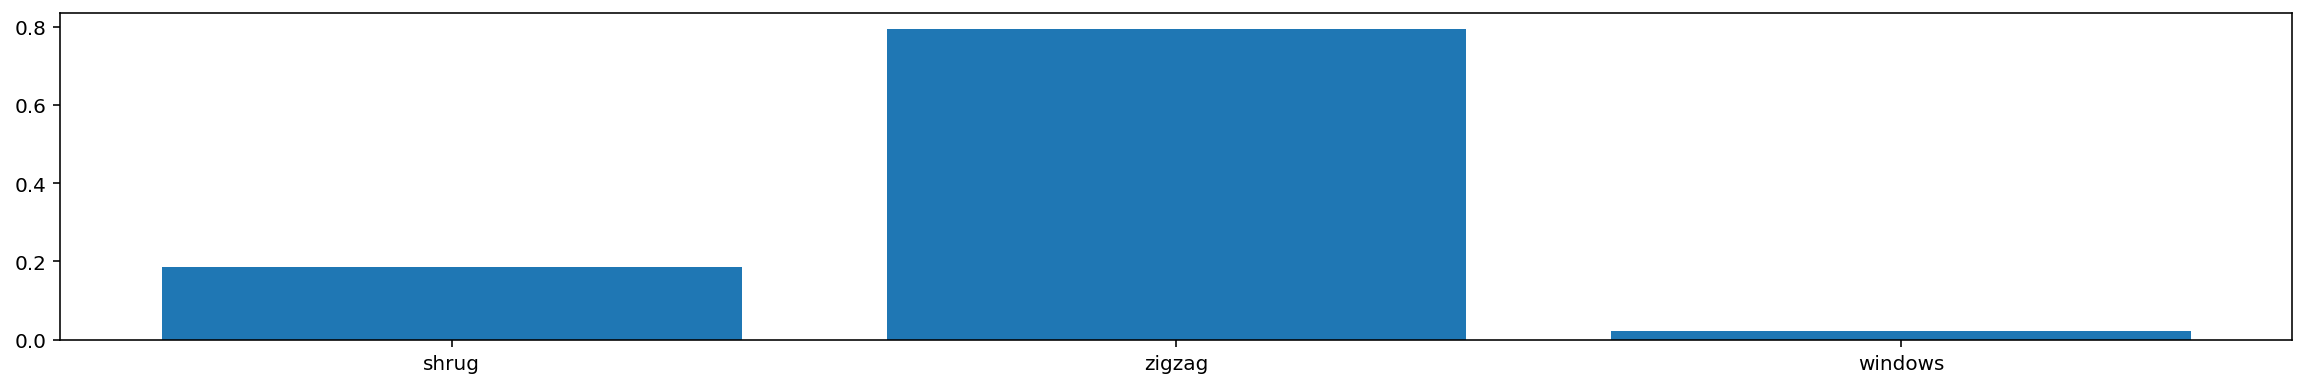

In [127]:
def softmax_logits(logits):
    prediction_list = softmax(logits)
    max_val = -1
    prediction = 0
    for i in range(len(prediction_list)):
        if prediction_list[i] > max_val:
            max_val = prediction_list[i]
            prediction = i
    
    return prediction

logits = ret[oname].flatten()
prob = softmax(logits)

print(prob)
print("predicted:", classes[softmax_logits(logits)], ", actual:", classes[int(test_output.tolist())])

plt.figure(figsize=(20, 3)) 
plt.bar(classes, prob)